In [1]:
import os
import pickle

In [2]:
final_model_path = "epoch199_WithClincal_03-08-2022 12-11-39"

In [3]:
# load testing.
with open(os.path.join("training_records", f"{final_model_path}.pkl"), 'rb') as f:
    training_record = pickle.load(f)

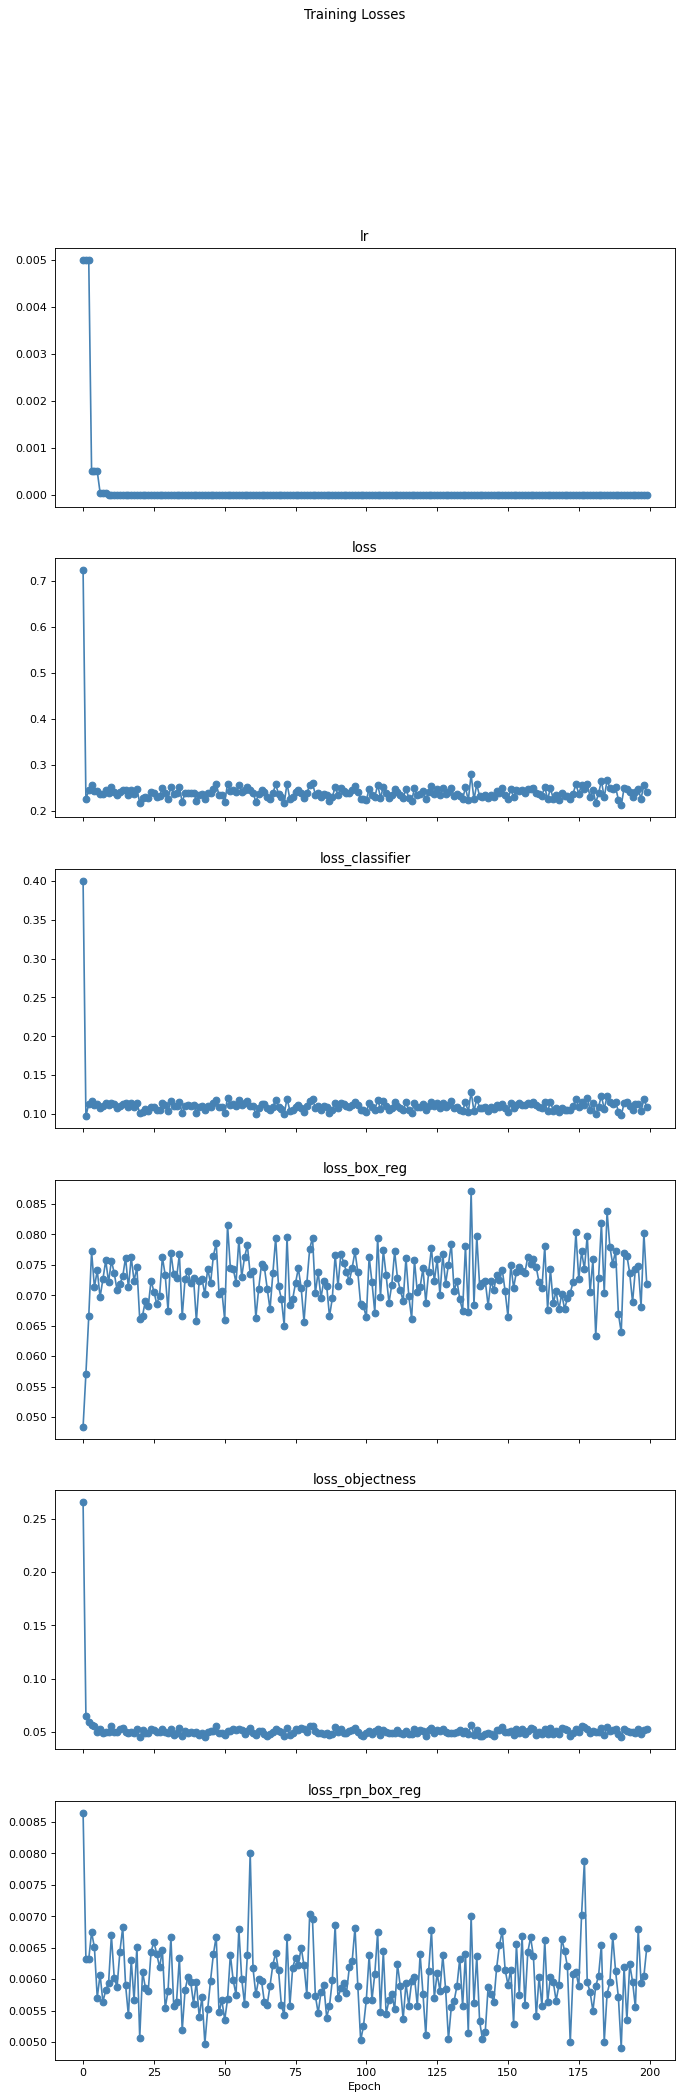

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

train_data_keys = training_record['train_data'][0].keys()

fig, subplots  = plt.subplots(
    len(train_data_keys), figsize=(10, 5* len(train_data_keys)), dpi=80, sharex=True)


fig.suptitle(f"Training Losses")

for i, k in enumerate(train_data_keys):
    subplots[i].set_title(k)
    subplots[i].plot([data[k] for data in training_record["train_data"]], marker='o', label=k, color='steelblue')
    # subplots[i].legend(loc="upper left")

subplots[-1].set_xlabel('Epoch')
plt.plot()
plt.pause(0.01)


In [5]:
test_evaluator = training_record['test_evaluator']

In [6]:
val_evaluators = training_record['val_evaluators']

In [7]:
val_evaluators[3].summarize()

IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000


In [11]:
val_evaluators[-1].stats

AttributeError: 'CocoEvaluator' object has no attribute 'stats'

In [12]:
# let's load the model and do evaluation here.

In [18]:
import math
import sys
import time
import torch

from data.dataset import REFLACXWithClinicalAndBoundingBoxDataset
from utils.transforms import get_transform

XAMI_MIMIC_PATH = "D:\XAMI-MIMIC"

use_gpu = torch.cuda.is_available()
device = 'cuda' if use_gpu else 'cpu'
print(f"Will be using {device}")

Will be using cuda


In [22]:
## Prepare data
batch_size = 16

train_dataset = REFLACXWithClinicalAndBoundingBoxDataset(
    XAMI_MIMIC_PATH=XAMI_MIMIC_PATH,
    split_str="train",
    transforms=get_transform(train=True),
)

val_dataset = REFLACXWithClinicalAndBoundingBoxDataset(
    XAMI_MIMIC_PATH=XAMI_MIMIC_PATH,
    split_str="val",
    transforms=get_transform(train=False),
)

test_dataset = REFLACXWithClinicalAndBoundingBoxDataset(
    XAMI_MIMIC_PATH=XAMI_MIMIC_PATH,
    split_str="test",
    transforms=get_transform(train=False),
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=REFLACXWithClinicalAndBoundingBoxDataset.collate_fn
)


val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, collate_fn=REFLACXWithClinicalAndBoundingBoxDataset.collate_fn
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, collate_fn=REFLACXWithClinicalAndBoundingBoxDataset.collate_fn
)



In [20]:
import torchvision
from models.rcnn import MultimodalFasterRCNN

## Weights of the first 2 layer of the ResNet backbone are fixed.
trainable_backbone_layers = torchvision.models.detection.backbone_utils._validate_trainable_layers(
    True, None, 5, 3
)
backbone = torchvision.models.detection.backbone_utils.resnet_fpn_backbone(
    "resnet50", pretrained=True, trainable_layers=trainable_backbone_layers
)
backbone.out_channels = 256


######################## For MobileNet backbone ########################
# from torchvision.models.detection.faster_rcnn import AnchorGenerator
# backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# backbone.out_channels = 1280
# anchor_generator = AnchorGenerator(
#     sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),)
# )
# roi_pooler = torchvision.ops.MultiScaleRoIAlign(
#     featmap_names=["0"], output_size=7, sampling_ratio=2
# )
########################################################################

model = MultimodalFasterRCNN(
    backbone,
    num_classes=len(train_dataset.labels_cols) + 1,
    rpn_anchor_generator=None,
    box_roi_pool=None,
    use_clinical=True, # Define whether we use clinical data in our model.
)

# move model to the right device
model.to(device)

MultimodalFasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
     

In [21]:
model.load_state_dict(torch.load(os.path.join('trained_models', final_model_path ), map_location=device))

<All keys matched successfully>

In [ ]:
from utils.coco_utils import get_coco_api_from_dataset
from utils.coco_eval import CocoEvaluator

from utils import detect_utils

In [ ]:
def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types

In [ ]:
n_threads = torch.get_num_threads()
# FIXME remove this and make paste_masks_in_image run on the GPU
torch.set_num_threads(1)
cpu_device = torch.device("cpu")
model.eval()
metric_logger = detect_utils.MetricLogger(delimiter="  ")
header = "Test:"

coco = get_coco_api_from_dataset(test_dataloader.dataset)
iou_types = _get_iou_types(model)
coco_evaluator = CocoEvaluator(coco, iou_types)

for images, clinical_num, clinical_cat, targets in metric_logger.log_every(test_dataloader, 100, header):
    images = list(img.to(device) for img in images)
    clinical_num = [t.to(device) for t in clinical_num]
    clinical_cat = [t.to(device) for t in clinical_cat]

    torch.cuda.synchronize()
    model_time = time.time()
    outputs = model(images, (clinical_num, clinical_cat))

    outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
    model_time = time.time() - model_time

    res = {
        target["image_id"].item(): output
        for target, output in zip(targets, outputs)
    }
    evaluator_time = time.time()
    coco_evaluator.update(res)
    evaluator_time = time.time() - evaluator_time
    metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

# gather the stats from all processes
metric_logger.synchronize_between_processes()
print("Averaged stats:", metric_logger)
coco_evaluator.synchronize_between_processes()

# accumulate predictions from all images
coco_evaluator.accumulate()
coco_evaluator.summarize()
torch.set_num_threads(n_threads)
